In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

#######
c_km = 3e8/1000

# Axion mass
m_a = 3e-6
m_a_s = m_a/6.58e-16

# Converting frequency to speed
n = 600
vmin = 0.1
vmax = 800
omega_min = (m_a_s)*(1+(vmin/c_km)**2.0/2.0)
omega_max = (m_a_s)*(1+(vmax/c_km)**2.0/2.0)
axionBW = (omega_max-omega_min)
omega = linspace(omega_min-0.21*axionBW,omega_max+0.21*axionBW,n)
omega_min = omega[0]
omega_max = omega[-1]
domega = omega[1]-omega[0]
v = c_km*sqrt(2*(omega-m_a_s)/omega)
v[omega<=m_a_s] = 0.0
dv = (1.0/m_a_s)*(c_km/v)*c_km
dv[omega<=m_a_s] = 0.0



# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True) # Sausage
fv_lab = zeros(shape=(nshards,n))
fv_gf = zeros(shape=(nshards,n))

for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv_lab[i] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)
    
    fv_gf[i] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,EscapeSpeed=False)

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:61: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))



/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide



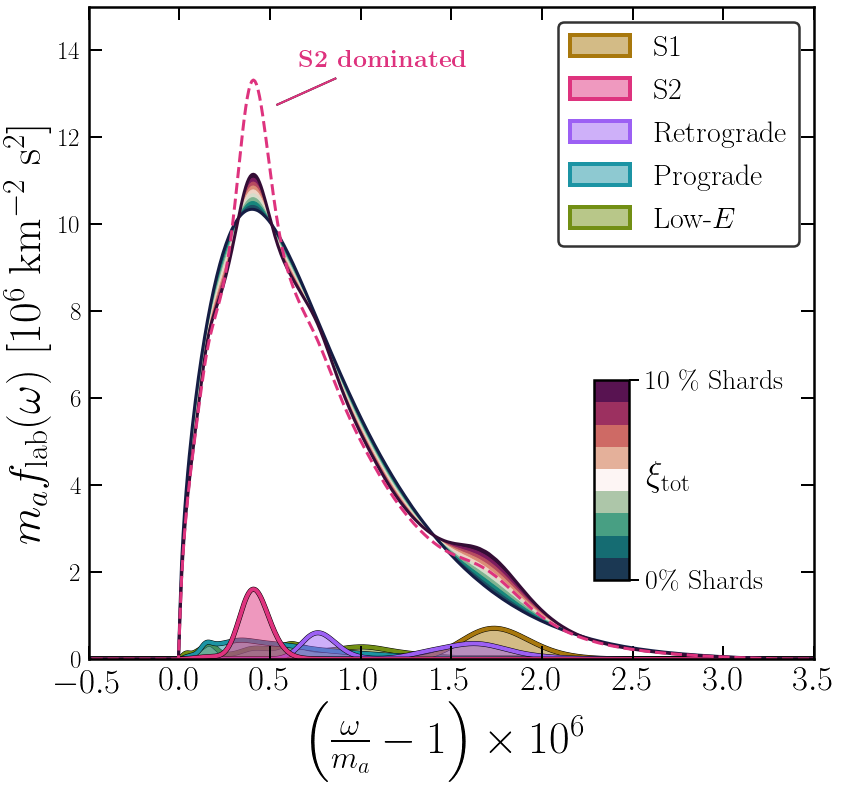

In [7]:
import cmocean
import matplotlib.patheffects as pe

labs = ['S1','S2','Retrograde','Prograde','Low-$E$']
nex = size(labs)
col_ex = (cmocean.cm.phase(linspace(0,0.9,nex)))


#Figure setup
xlab = r"$\left(\frac{\omega}{m_a} - 1\right) \times 10^6$"
ylab = r"$m_a f_{\rm lab}(\omega)$ [$10^6$ km$^{-2}$ s$^{2}$]"
fig,ax = MySquarePlot(xlab,ylab)

eta_saus = 0.2
fvs_lab = sum(fv_lab,0)

fvnS2 = sum(fv_lab[3:,:],0)+fv_lab[0,:]
fvnS2 /= trapz(fvnS2,v)

fvS2 = fv_lab[1,:]+fv_lab[2,:]
fvS2 /= trapz(fvS2,v)

fvS2 = 0.5*fvS2+0.5*fvnS2

fvs_gf = sum(fv_gf,0)
n_xi = 10
xi_max = 0.15
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cmocean.cm.curl(linspace(0,1,n_xi)))
cmap = cmocean.cm.curl

#ys = domega*dv
ys = (1.0/v)*1e6
x = 1e6*(omega/m_a_s-1)
ys[x<0.0] = 0.0

# xi range
y2 = (1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab
for j in range(0,n_xi):
    i = n_xi-1-j
    xi = xi_vals[i]
    y = (1-eta_saus-xi)*fv_Iso_lab + eta_saus*fv_Saus_lab + xi*fvs_lab
    ax.fill_between(x,ys*y,y2=ys*y2,color=col[i,:],alpha=1.0)
    #ax.plot(x,ys*y,'-',color=col[i,:],linewidth=3) 


    
# Range
y0_lab = (1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab
y1_lab = (1-eta_saus-xi_max)*fv_Iso_lab + eta_saus*fv_Saus_lab + xi_max*fvs_lab
y0_gf = (1-eta_saus)*fv_Iso_gf + eta_saus*fv_Saus_gf
y1_gf = (1-eta_saus-xi_max)*fv_Iso_gf + eta_saus*fv_Saus_gf + xi_max*fvs_gf
ax.plot(x,ys*y0_lab,'-',color=col[0,:],linewidth=3)
ax.plot(x,ys*y1_lab,'-',color=col[-1,:],linewidth=3)
# ax.plot(x,ys*y0_gf,'--',color=col[0,:],linewidth=3)
# ax.plot(x,ys*y1_gf,'--',color=col[-1,:],linewidth=3)

# s2
ys2 = (1-eta_saus-xi_max)*fv_Iso_lab + eta_saus*fv_Saus_lab + xi_max*fvS2
#ax.plot(x,ys2*ys,'--',color='k',linewidth=4)
ax.plot(x,ys2*ys,'--',color=col_ex[1,:],linewidth=3)
plt.gcf().text(0.35,0.81,r'{\bf S2 dominated}',fontsize=25,color=col_ex[1,:])
plt.plot([0.26,0.34],[0.85,0.89],'-',color='k',transform=ax.transAxes,lw=2,zorder=10)
plt.plot([0.26,0.34],[0.85,0.89],'-',color=col_ex[1,:],transform=ax.transAxes,lw=2,zorder=10)


# second "legend" for with/without GF
# ax.plot([0.6,0.87],[0.008,0.008], 'k-',linewidth=3.5)
# ax.plot([0.6,0.87],[0.0076,0.0076], 'k--',linewidth=3.5)
# ax.text(0.91,0.008-0.0001,'without grav. focusing',fontsize=26)
# ax.text(0.91,0.0076-0.0001,'with grav. focusing',fontsize=26)



# Individual streams
j = 0
zo = [-2,0,-1,-3,-4]
for idi in ['S1','S2','R','Ca','N']: 
    mask1 = zeros(shape=nshards)==1
    for i in range(0,nshards):
        mask1[i] = names[i].startswith(idi)
    y = xi_max*sum(fv_lab[mask1,:],0)
    y_gf = xi_max*sum(fv_gf[mask1,:],0)
    ax.fill_between(x,ys*y,color=col_ex[j,:],lw=4,alpha=0.5,zorder=zo[j]) 
    ax.plot(x,y*ys,color='k',lw=5,alpha=1.0,zorder=zo[j]) 
    ax.plot(x,y*ys,color=col_ex[j,:],lw=4,alpha=1.0,zorder=zo[j]) 
    #ax.plot(x,y_gf*ys,'--',color=col_ex[j,:],lw=3,alpha=1.0,zorder=zo[j]) 
    ax.fill_between([-1,-1],[-10,-30],facecolor=col_alpha(col_ex[j,:],0.5),edgecolor=col_ex[j,:],lw=4,label=labs[j],zorder=zo[j])
    #ax.fill_between([-1,-1],[-10,-30],lw=4,path_effects=[pe.Stroke(linewidth=5, foreground='k')])
    j += 1
    
# Legend lines
leg = ax.legend(loc='upper right',fontsize=30,edgecolor='k')
leg.get_frame().set_linewidth(2.5)
 
    
# Plot fiddling
ax.set_xlim(left=-0.5,right=3.5)
ax.set_ylim(bottom=0.0,top=15.0)
plt.xticks(fontsize=35)


# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-30, 0, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.72,0.32,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_axionspectrum'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

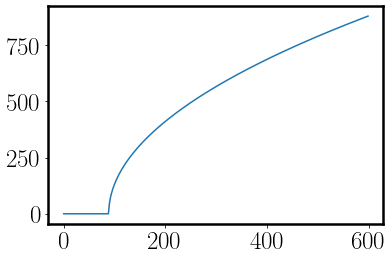

In [75]:
# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)


# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True) # Sausage
fv_lab = zeros(shape=(nshards,n))
fv_gf = zeros(shape=(nshards,n))

for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv_lab[i] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)
    

In [ ]:
def RSdef(fv_lab):
    fv0 = (ys*((1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab))
    R0 = trapz(fv0**2.0,omega)**(-0.25)
    RS = zeros(shape=n_xi)
    for i in range(0,n_xi):
        xi = xi_vals[i]
        fv1 = (ys*((1-eta_saus-xi)*fv_Iso_lab + eta_saus*fv_Saus_lab + xi*fvs_lab))
        R1 = trapz(fv1**2.0,omega)**(-0.25)
        RS[i] = 100*(1-R1/R0)

print(RSdef(fv_lab))
print(RSdef(fvS2))